## FNO: Anti-derivaties

- Code:
  - https://github.com/hl4220/Extended-Physics-Informed-Neural-Operator/blob/main/Anti-derivative/PI_ExdeepOnet_Anti_dev.ipynb

- Data: ETH Zurich's course on "Deep Learning in Scienfitic Computing"
  - https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
  - https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz

- created: 2024.11.22

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # current gpu seed
torch.cuda.manual_seed_all(seed) # All gpu seed
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = False  # True로 하면 gpu에 적합한 알고리즘을 선택함.

### Data: Anti-derivatives

In [2]:
## Data
data_train = np.load("../data/antiderivative_aligned_train.npz", allow_pickle=True)
branch_inputs_train = data_train["X"][0]    # (n_samples, n_points)     Fs
trunk_inputs_train = data_train["X"][1]     # (n_points, 1)             coor
outputs_train = data_train["y"]             # (n_samples, n_points)     Y

data_test = np.load("../data/antiderivative_aligned_test.npz", allow_pickle=True)
branch_inputs_test = data_test["X"][0]      # (n_samples, n_points)
trunk_inputs_test = data_test["X"][1]       # (n_points, 1)
outputs_test = data_test["y"]               # (n_samples, n_points)

print(">> Train Data:", branch_inputs_train.shape, trunk_inputs_train.shape, outputs_train.shape)
print(">> Test Data: ", branch_inputs_test.shape, trunk_inputs_test.shape, outputs_test.shape)

>> Train Data: (150, 100) (100, 1) (150, 100)
>> Test Data:  (1000, 100) (100, 1) (1000, 100)


In [4]:
## Dataloader
from torch.utils.data import TensorDataset, DataLoader

grid_size = branch_inputs_train.shape[1]
n_train = branch_inputs_train.shape[0]
n_test = branch_inputs_test.shape[0]
batch_size = 32

x_train = torch.tensor(branch_inputs_train).float()
c_train = torch.tensor(trunk_inputs_train.flatten()).float().repeat(n_train, 1)
y_train = torch.tensor(outputs_train).float()

x_test = torch.tensor(branch_inputs_test).float()
c_test = torch.tensor(trunk_inputs_test.flatten()).float().repeat(n_test, 1)
y_test = torch.tensor(outputs_test).float()

print(">> Train Data:", x_train.shape, c_train.shape, y_train.shape)
print(">> Test Data: ", x_test.shape, c_test.shape, y_test.shape)

train_loader = DataLoader(TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

x, c, y = next(iter(train_loader))
print(">> Batch Data:", x.shape, c.shape, y.shape)

>> Train Data: torch.Size([150, 100]) torch.Size([150, 100]) torch.Size([150, 100])
>> Test Data:  torch.Size([1000, 100]) torch.Size([1000, 100]) torch.Size([1000, 100])
>> Batch Data: torch.Size([32, 100]) torch.Size([32, 100]) torch.Size([32, 100])


### Model

In [5]:
class SpectralConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def einsum(self, inputs, weights):
        # (batch_size, in_channels, grid_size), (in_channels, out_channels, grid_size) 
        # -> (batch_size, out_channels, grid_size)
        return torch.einsum("bix,iox->box", inputs, weights)

    def forward(self, x):
        # x: [batch_size, in_channels, grid_size]
        batch_size, grid_size = x.shape[0], x.shape[-1]

        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batch_size, self.out_channels, grid_size // 2 + 1).cfloat().to(x.device)
        out_ft[:, :, :self.modes] = self.einsum(x_ft[:, :, :self.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=grid_size)
        return x

In [6]:
class FNO1D(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.padding = 1  # pad the domain if input is non-periodic
        self.input_layer = nn.Linear(2, width)

        self.spect1 = SpectralConv1D(width, width, modes)
        self.spect2 = SpectralConv1D(width, width, modes)
        self.spect3 = SpectralConv1D(width, width, modes)
        self.conv1 = nn.Conv1d(width, width, kernel_size=1)
        self.conv2 = nn.Conv1d(width, width, kernel_size=1)
        self.conv3 = nn.Conv1d(width, width, kernel_size=1)
        self.activation = nn.Tanh()

        self.output_layer = nn.Sequential(
            nn.Linear(width, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, c):
        x = torch.concat([x.unsqueeze(-1), c.unsqueeze(-1)], dim=-1)
        x = self.input_layer(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])   # pad the domain if input is non-periodic

        x = self.activation(self.spect1(x) + self.conv1(x))
        x = self.activation(self.spect2(x) + self.conv2(x))
        x = self.activation(self.spect3(x) + self.conv3(x))

        # x = x[..., :-self.padding]        # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.output_layer(x)
        return x.squeeze()

### Training

In [7]:
## Training
learning_rate = 1e-3
n_epochs = 200
modes, width = 16, 64

model = FNO1D(modes, width).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    for x, c, y in train_loader:
        x, c, y = x.to(device), c.to(device), y.to(device)
        y_pred = model(x, c)
        loss = loss_fn(y_pred.squeeze(), y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, c, y in test_loader:
            x, c, y = x.to(device), c.to(device), y.to(device)
            y_pred = model(x, c)
            loss = loss_fn(y_pred.squeeze(), y)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:4d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"train_loss: {train_loss:.2e} | test_loss: {test_loss:.2e}")

[  20/200] (lr: 1.00e-03) train_loss: 4.16e-03 | test_loss: 2.95e-03
[  40/200] (lr: 1.00e-03) train_loss: 9.64e-04 | test_loss: 9.34e-04
[  60/200] (lr: 5.00e-04) train_loss: 4.92e-04 | test_loss: 5.85e-04
[  80/200] (lr: 5.00e-04) train_loss: 3.95e-04 | test_loss: 4.27e-04
[ 100/200] (lr: 2.50e-04) train_loss: 3.88e-04 | test_loss: 4.86e-04
[ 120/200] (lr: 2.50e-04) train_loss: 2.09e-04 | test_loss: 2.89e-04
[ 140/200] (lr: 2.50e-04) train_loss: 2.07e-04 | test_loss: 2.77e-04
[ 160/200] (lr: 1.25e-04) train_loss: 1.72e-04 | test_loss: 2.43e-04
[ 180/200] (lr: 1.25e-04) train_loss: 1.60e-04 | test_loss: 2.35e-04
[ 200/200] (lr: 6.25e-05) train_loss: 1.55e-04 | test_loss: 2.19e-04


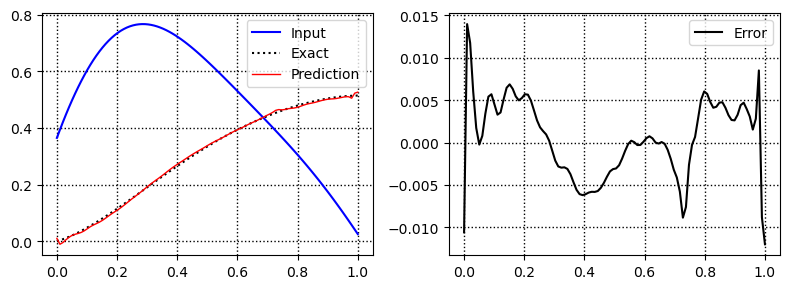

In [8]:
model.eval()
with torch.no_grad():
    x_test, c_test = x_test.to(device), c_test.to(device)
    y_pred = model(x_test, c_test)

x_test_np = x_test.cpu().detach().numpy()
c_test_np = c_test.cpu().detach().numpy()
y_test_np = y_test.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()

idx = 10
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.plot(c_test_np[idx], x_test_np[idx], 'b', label="Input")
ax1.plot(c_test_np[idx], y_test_np[idx], 'k:', label="Exact")
ax1.plot(c_test_np[idx], y_pred_np[idx], 'r', lw=1, label="Prediction")
ax2.plot(c_test_np[idx], y_test_np[idx] - y_pred_np[idx], 'k', label="Error")

for ax in (ax1, ax2):
    ax.legend(loc="upper right")
    ax.grid(color='k', ls=':', lw=1)
fig.tight_layout()
plt.show()